This is a note for myself on the tag-based error correction program that I coded up (Figure 1). This is inspired from a combination of two works, [circ-seq](http://www.ncbi.nlm.nih.gov/pubmed/24243955) and [safe-seq](http://www.pnas.org/content/108/23/9530).

![](indexed_tgirt.png)

# Indexed R1R #

For a given read 1, the first 13 bases is the index as below.

<center>
CGA TG[N NNN NNN NNN NNN] TCT GAA CTC CAG TCA CAC TGA TAT CTC GTA TGC CGT CTT CTG CTT GAA AAA AAA AAGG GGG G
</center>

Reads with same index are grouped together in a dictionary (python).


# Concensus base #

For a cluster of reads (group), bases at a single position (a column) were extracted, concensus base was predicted using maximum likelihood with priors as Phred quality scores (Q):

$$Q = -10 log_{10} P_e$$
$$P_e = 10 ^{\frac{-Q}{10}}$$
where $P_e$ is the error probability.

For a give position in the read cluster $J$, read $i$, likelihood of identity of the concensus base ($I$) being $b$ given output base ($r$): 

$$ 
P(I=b | r_{i, j},Q_{i,j}) \propto \left\{ \begin{array}{cl}
         1 - 10^\frac{-Q_{i,j}}{10} & \mbox{if $r_{i,j} = b$};\\
        10^\frac{-Q_{i,j}}{10} & \mbox{if $r_{i,j} \neq b$}.\end{array} \right.
$$

$$
P(I=b | r_{j},Q_{j}) = \frac{\prod_i (P(I=b|r_{i, j},Q_{i, j}))}{\sum_{d \in \{A,C,T,G\}}\prod_i (P(I=d|r_{i, j},Q_{i, j}))}
$$

For the following example illutrated with **python**, if a position in a read cluster contains bad sequencing reads [C,C,A,A,A,A,A,G,T] with Phred scores [),),),A,-,-,A,),A]:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import logsumexp
sns.set_style('white')
min_q = 33
max_q = 73
max_prob = 0.999999
acceptable_bases = np.array(['A','C','T','G'], dtype='S1')

In [2]:
def probToString(posteriors):
    posteriors = np.array(posteriors, dtype=np.float64)
    posteriors = np.clip(posteriors,0, max_prob)
    quality =  -10 * np.log10(1 - posteriors)
    quality = np.array(quality,dtype=np.int8) + 33
    quality = np.clip(quality, min_q, max_q)
    quality = ''.join(map(chr,quality))
    return quality

def qualToInt(q):
    return ord(q)-33

def qual2Prob(base_qual):
    '''
    Given a q list,
    return a list of prob
    '''
    return np.power(10, np.true_divide(-base_qual,10))

def calculatePosterior(column_bases, column_qualities, guess_base):
    
    # find quality of bases either hit/miss
    qual_missed = column_qualities[column_bases!=guess_base] 
    qual_hit = column_qualities[column_bases==guess_base]
    
    # calculat probability of observing the events
    log_hit_prob = np.sum(np.log(1 - qual2Prob(qual_hit)))
    log_missed_prob = np.sum(np.log(np.true_divide(qual2Prob(qual_missed),3)))
    log_likelihood = log_hit_prob + log_missed_prob
    return log_likelihood

In [3]:
column_bases = np.array(list('CCAAAAAGT'))
column_qualities = list(')))A--A)A')
column_qualities = np.array(list(map(qualToInt, column_qualities)))
acceptable_bases = list(set(column_bases))
loglikelihoods = [calculatePosterior(column_bases, column_qualities, guess_base) for guess_base in acceptable_bases]

In [4]:
log_posteriors = loglikelihoods - logsumexp(loglikelihoods)

Text(0,0.5,'Posterior probability')

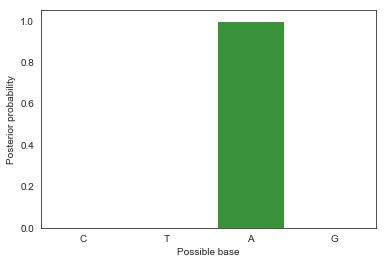

In [5]:
ax = plt.subplot(111)
sns.barplot(x=acceptable_bases, y = np.exp(log_posteriors), ax = ax)
ax.set_xlabel('Possible base')
ax.set_ylabel('Posterior probability')

In [6]:
np.exp(log_posteriors)

array([  3.55511496e-10,   6.65792687e-09,   9.99999993e-01,
         2.23188987e-11])

# Correcting base calling quality #

As Illumina produce phred33 for base calling quality fastq files, we need to scale Q score back to the range of [0,40].

In python, it would be:

```
minQ = 33
maxQ = 73
quality = -10 * np.log10(1 - posterior) + 33 if posterior < 1 else maxQ
quality = np.clip(quality, minQ, maxQ)
```

The corrected score for the above sample of a read base *C* would be: **`r intToUtf8(as.integer(Quality)+33)` **

![](http://www.omixon.com/wp-content/uploads/2013/06/illumina_fastq_coding.png)